# Retail Store Analysis

# Introduction

In ecommerce companies like online retails, customer segmentation is necessary in order to understand customers behaviors. It leverages aqcuired customer data like the one we have in our case, **transactions data** in order to divide customers into groups. 

Our goal in this Notebook is to cluster our customers to get insights in:
- Increasing **revenue** (Knowing customers who present most of our revenue)
- Increasing customer **retention**
- Discovering **Trends and patterns** 
- Defining **customers at risk**

We will do **RFM Analysis** as a first step and then **combine RFM with predictive algorithms (k-means)**. 

RFM Analysis answers these questions:
- Who are our best customers?
- Who has the potential to be converted in more profitable customers?
- Which customers we must retain?
- Which group of customers is most likely to respond to our current campaign?


# Import modules

In [1]:
import pandas as pd
import numpy as np

import time, warnings
warnings.filterwarnings("ignore")
import datetime as dt

#modules for predictive models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

# Get the Data

In [2]:
#load the dataset
retail_df = pd.read_excel("Online Retail.xlsx")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# shape of the data
retail_df.shape

# There is 5.41L rows and 8columns are there

(541909, 8)

In [10]:
# Five point summary for numerical variables
retail_df.describe().T

# For both quantity and unitprice, minimum price is negative. But in reality its not possible.
# Presence of missing values are seen in customerID column.

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [11]:
# Five point summary for categorical variables
retail_df.describe(include='object').T

# Presence of missing values are seen in Description column.
# United Kingdom country is repeated more in dataset.

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


In [12]:
# Check for datatypes
retail_df.info()

# CustomerID should be object type but it is float datatype is seen.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# Prepare the Data

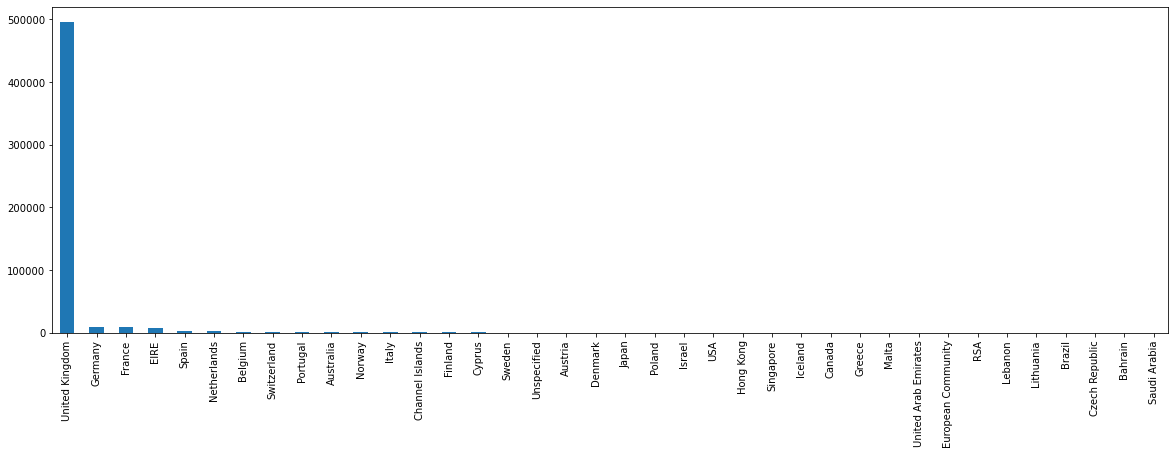

In [16]:
# count of customers based on geography
plt.figure(figsize=(20,6))
retail_df['Country'].value_counts().plot(kind='bar')
plt.show()

As customer clusters may vary by geography, I’ll restrict the data to only United Kingdom customers, which contains most of our customers historical data.

In [33]:
# Modify dataset wrt to UK
retail_uk = retail_df[retail_df['Country']=='United Kingdom']

#check the shape
retail_uk.shape

(495478, 8)

In [34]:
# Let consider quantity variables
print('Minimum quantity :', min(retail_uk['Quantity']))
print('Maximum quantity :', max(retail_uk['Quantity']))

# Presence of negetive quantity is observed and lets remove it
retail_uk = retail_uk[retail_uk['Quantity'] >= 0]
retail_uk.shape

Minimum quantity : -80995
Maximum quantity : 80995


(486286, 8)

In [48]:
# Let consider data for last 1year
print('old date :', min(retail_uk['InvoiceDate']))
print('latest date :', max(retail_uk['InvoiceDate']))

from datetime import timedelta
a = retail_uk['InvoiceDate'].max() - timedelta(days=365)
retail_uk = retail_uk[retail_uk['InvoiceDate'] >= a]
retail_uk.shape

old date : 2010-12-09 12:49:00
latest date : 2011-12-09 12:49:00


(467464, 8)

In [51]:
# Null values in the dataset
retail_uk.isnull().sum() /retail_uk.shape[0] * 100

# Almost 26.8% percentage of null/missing values are observed in dataset.
# In CustomerID column, can't impute any values and hence it is removed.

InvoiceNo       0.000000
StockCode       0.000000
Description     0.120651
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     26.820675
Country         0.000000
dtype: float64

In [54]:
# droping null values
retail_uk.dropna(how='any', inplace=True)

In [56]:
retail_uk.isnull().sum().sum()

0

In [57]:
retail_uk.shape

(342087, 8)

In [59]:
#Duplicated values
retail_uk[retail_uk.duplicated()]



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
20320,538035,20728,LUNCH BAG CARS BLUE,3,2010-12-09 13:03:00,1.65,16065.0,United Kingdom
20418,538051,22659,LUNCH BOX I LOVE LONDON,2,2010-12-09 13:24:00,1.95,18041.0,United Kingdom
22232,538155,21907,I'M ON HOLIDAY METAL SIGN,1,2010-12-09 16:52:00,2.10,16907.0,United Kingdom
22355,538166,21915,RED HARMONICA IN BOX,5,2010-12-09 18:09:00,1.25,17965.0,United Kingdom
22402,538168,22739,RIBBON REEL CHRISTMAS SOCK BAUBLE,5,2010-12-09 19:23:00,1.65,14702.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [84]:
retail_uk.shape

(342087, 8)

In [86]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )

Summary..
Number of transactions:  15988
Number of products bought:  3611
Number of customers: 3860


# RFM Analysis

RFM (**Recency, Frequency, Monetary**) analysis is a customer segmentation technique that uses past purchase **behavior** to divide customers into groups. <br> RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.
- RECENCY (R): Days since last purchase 
- FREQUENCY (F): Total number of purchases 
- MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.


## Recency


To calculate recency, we need to choose a date point from which we evaluate **how many days ago was the customer's last purchase**.

In [87]:
#last date available in our dataset
retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

The last date we have is 2011-12-09 so we will use it as reference.

In [88]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [89]:
#create a new column called date which contains the recent purchase of product
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date

In [90]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
20206,538014,22969,HOMEMADE JAM SCENTED CANDLES,12,2010-12-09 12:49:00,1.45,14440.0,United Kingdom,2010-12-09
20207,538014,72802B,OCEAN SCENT CANDLE IN JEWELLED BOX,12,2010-12-09 12:49:00,4.25,14440.0,United Kingdom,2010-12-09
20208,538014,85066,CREAM SWEETHEART MINI CHEST,12,2010-12-09 12:49:00,12.75,14440.0,United Kingdom,2010-12-09
20209,538014,82483,WOOD 2 DRAWER CABINET WHITE FINISH,6,2010-12-09 12:49:00,5.95,14440.0,United Kingdom,2010-12-09
20210,538014,82486,WOOD S/3 CABINET ANT WHITE FINISH,6,2010-12-09 12:49:00,7.95,14440.0,United Kingdom,2010-12-09


In [91]:
#group by customers and check last date of purshace
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [92]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [93]:
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [94]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

Now we have the recency attribute created. e.g: Customer with ID = 12346 did his/her last purshace 325 days ago.

## Frequency

Frequency helps us to know **how many times a customer purchased from us**. To do that we need to check how many invoices are registered by the same customer.

In [96]:
# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,195
3,12749.0,5
4,12820.0,4


## Monetary

Monetary attribute answers the question: **How much money did the customer spent over time?**

To do that, first, we will create a new column total cost to have the total price per invoice.

In [97]:
#create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [101]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3696.73
3,12749.0,98.35
4,12820.0,58.20


## Create RFM Table

In [102]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,10
2,12748.0,0,195
3,12749.0,3,5
4,12820.0,3,4


In [103]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,195,3696.73
12749.0,3,5,98.35
12820.0,3,4,58.20


Customer with ID = 12346 has recency: 325 days, frequency:1, and monetary: 77183,60 £.

### RFM Table Correctness verification

In [104]:
retail_uk[retail_uk['CustomerID']==12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [105]:
(now - dt.date(2011,1,18)).days == 325

True

As we can see our RFM table is correct. The first customer bought only once, and only one product with huge amount. 

## Customer segments with RFM Model

Before moving to customer segments, Let's see the application of Pareto Principle – commonly referred to as the 80-20 rule on our dataset by applying it to our RFM variables.

Pareto’s rule says **80% of the results come from 20% of the causes**.

Similarly, **20% customers contribute to 80% of your total revenue**. Let's verify that because that will help us know which customers to focus on when marketing new products.

### Applying 80-20 rule

In [106]:
#get the 80% of the revenue
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ",round(pareto_cutoff,2))

The 80% of total revenue is:  889368.02


In [115]:
customers_rank = rfm_df
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,10,658.89,182.0
12748.0,0,195,3696.73,34.0
12749.0,3,5,98.35,1139.0
12820.0,3,4,58.20,1664.5


### Top Customers

In [119]:
customers_rank.sort_values('Rank',ascending=True)

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
16446.0,0,2,168471.25,1.0
12346.0,325,1,77183.60,2.0
15098.0,182,3,39916.50,3.0
18102.0,0,57,39646.45,4.0
17949.0,1,44,28685.69,5.0
...,...,...,...,...
15503.0,362,1,0.42,3856.5
15645.0,18,1,0.42,3856.5
13271.0,37,1,0.39,3858.5


In [120]:
#get top 20% of the customers
top_20_cutoff = 3863 *20 /100
top_20_cutoff

772.6

In [122]:
#sum the monetary values over the customer with rank <=773
revenueByTop20 = customers_rank[customers_rank['Rank'] <= 772]['Monetary'].sum()
revenueByTop20

975311.3599999999

In our case, the 80% of total revenue is not achieved by the 20% of TOP customers but approximately, it does, because they are less than our 20% TOP customers who achieve it. It would be interesting to study this group of customers because they are those who make our most revenue.

### Applying RFM score formula

The simplest way to create customers segments from RFM Model is to use **Quartiles**. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

Note: Quintiles (score from 1-5) offer better granularity, in case the business needs that but it will be more challenging to create segments since we will have 5*5*5 possible combinations. So, we will use quartiles.

#### RFM Quartiles

In [123]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary,Rank
0.25,17.00,1.0,17.4000,965.75
0.50,49.00,2.0,45.0000,1930.00
0.75,133.25,5.0,121.4825,2896.00


In [124]:
quantiles.to_dict()

{'Recency': {0.25: 17.0, 0.5: 49.0, 0.75: 133.25},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.4, 0.5: 45.0, 0.75: 121.4825},
 'Rank': {0.25: 965.75, 0.5: 1930.0, 0.75: 2896.0}}

#### Creation of RFM segmentation table

We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [137]:
rfm_segmentation = rfm_df

In [138]:
#create rfm segmentation table
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].map(lambda x:4 
                                if x <= rfm_segmentation['Recency'].quantile(0.25) else 3 
                                if x <= rfm_segmentation['Recency'].quantile(0.50) else 2 
                                if x <= rfm_segmentation['Recency'].quantile(0.75) else 1)

rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].map(lambda x:1 
                                if x <= rfm_segmentation['Frequency'].quantile(0.25) else 2 
                                if x <= rfm_segmentation['Frequency'].quantile(0.50) else 3 
                                if x <= rfm_segmentation['Frequency'].quantile(0.75) else 4)

rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].map(lambda x:1 
                                if x <= rfm_segmentation['Monetary'].quantile(0.25) else 2 
                                if x <= rfm_segmentation['Monetary'].quantile(0.50) else 3 
                                if x <= rfm_segmentation['Monetary'].quantile(0.75) else 4)

rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4
12747.0,2,10,658.89,182.0,4,4,4
12748.0,0,195,3696.73,34.0,4,4,4
12749.0,3,5,98.35,1139.0,4,3,3
12820.0,3,4,58.20,1664.5,4,3,3


Now that we have the score of each customer, we can represent our customer segmentation.<br>
First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [140]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114
12747.0,2,10,658.89,182.0,4,4,4,444
12748.0,0,195,3696.73,34.0,4,4,4,444
12749.0,3,5,98.35,1139.0,4,3,3,433
12820.0,3,4,58.20,1664.5,4,3,3,433


Best Recency score = 4: most recently purchase.
Best Frequency score = 4: most quantity purchase.
Best Monetary score = 4: spent the most.

Let's see who are our **Champions** (best customers).

In [141]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
18102.0,0,57,39646.45,4.0,4,4,4,444
17949.0,1,44,28685.69,5.0,4,4,4,444
17450.0,8,44,25953.51,6.0,4,4,4,444
16013.0,3,45,17163.28,8.0,4,4,4,444
16333.0,7,22,14418.96,9.0,4,4,4,444
15769.0,7,25,11660.84,11.0,4,4,4,444
12901.0,8,28,9230.45,12.0,4,4,4,444
13798.0,1,56,7786.26,13.0,4,4,4,444
16684.0,4,28,7700.08,14.0,4,4,4,444


We can find [here](http://www.blastam.com/blog/rfm-analysis-boosts-sales) a suggestion of key segments and then we can decide which segment to consider for further study.

**Note:** the suggested link use the opposite valuation: 1 as highest/best score and 4 is the lowest.

**How many customers do we have in each segment?**

In [142]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  965
Almost Lost:  64
Lost Customers:  10
Lost Cheap Customers:  352


Now that we knew our customers segments we can choose how to target or deal with each segment.

For example:

**Best Customers - Champions**: Reward them. They can be early adopters to new products. Suggest them "Refer a friend".

**At Risk**: Send them personalized emails to encourage them to shop.

More ideas about what actions to perform in [Ometria](http://54.73.114.30/customer-segmentation#).

### Conclusion - perspective from this level of customer segmentation
To gain even further insight into customer behavior, we can dig deeper in the relationship between RFM variables.  

RFM model can be used in conjunction with certain predictive models like **k-means clustering**, **Logistic Regression** and **Recommendation** to produce better informative results on customer behavior.

We will go for k-means since it has been widely used for Market Segmentation and it offers the advantage of being simple to implement, following Andrew Ng who advice in his Machine Learning course, start with a dirty and simple model then move to more complex models because simple implementation helps having a first glance at the data and know where/how to exploit it better.

## Applying K-means clustering on RFM variables

### Preprocess Data

In [143]:
# Remove unneccesary columns
rfm_data = rfm_df.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore','Rank'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,195,3696.73
12749.0,3,5,98.35
12820.0,3,4,58.20


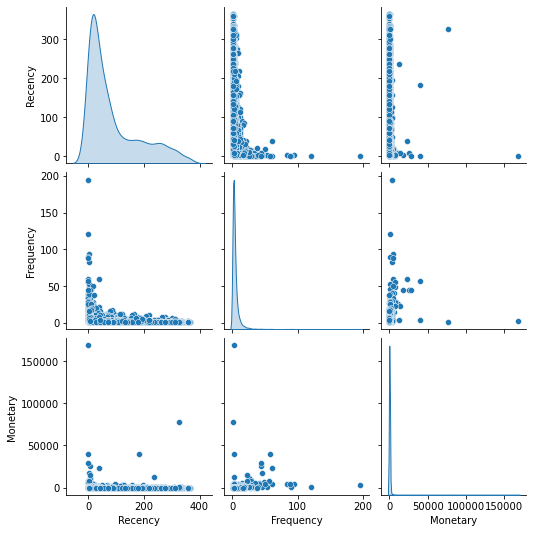

In [144]:
sns.pairplot(rfm_data, diag_kind='kde')
plt.show()

# Variables are right skewed

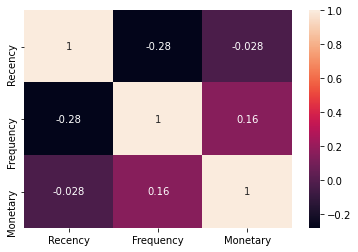

In [145]:
# Correlation map
sns.heatmap(rfm_data.corr(), annot=True)
plt.show()

# No strong co-relation is seen between the variables

In [146]:
# Transforming data using Powertransformer
# Both standadizing and normalisation is done using powertransformer
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

rfm_pt = pt.fit_transform(rfm_data)

In [147]:
rfm_pt_df = pd.DataFrame(rfm_pt, columns=rfm_data.columns)
rfm_pt_df.head()

,Recency,Frequency,Monetary
0,1.685545,-1.147956,3.617133
1,-1.735283,1.489684,1.638269
2,-2.224939,2.348316,2.472318
3,-1.591953,0.913713,0.527218
4,-1.591953,0.680599,0.182384


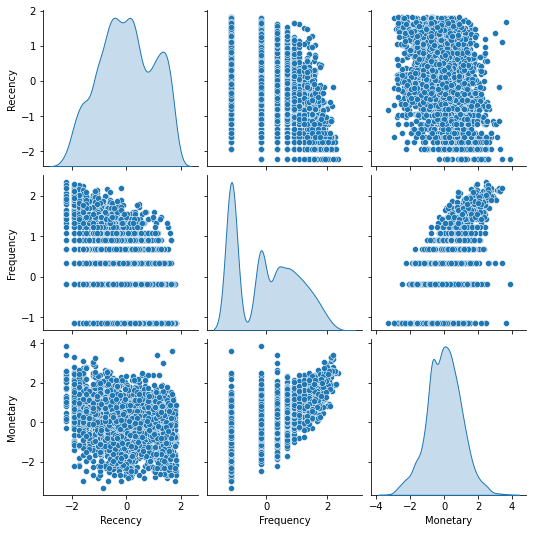

In [148]:
sns.pairplot(rfm_pt_df, diag_kind='kde')
plt.show()

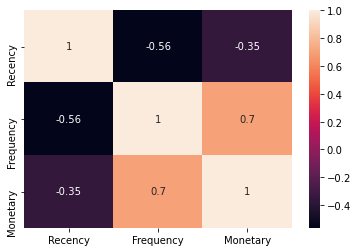

In [149]:
sns.heatmap(rfm_pt_df.corr(), annot=True)
plt.show()

# KMeans

A common challenge with k-means is that you must tell it how many clusters you expect. Figuring out how many clusters we need is not obvious from data, thus we will try different clusters numbers and check their [silhouette coefficient](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). The [elbow](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method) method can be used to determine the number of clusters as well.

**Note:** K-means is sensitive to initializations because those initializations are critical to quality of optima found. Thus, we will use smart initialization called ***k-means++***.

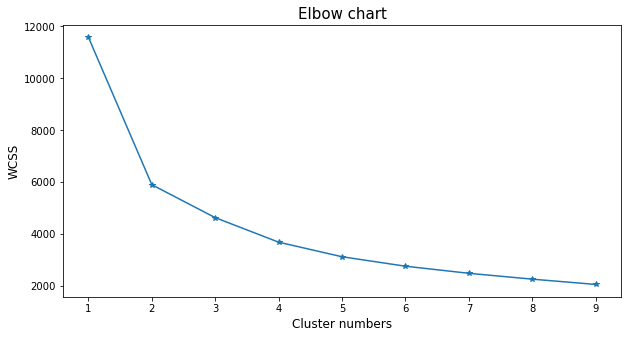

In [170]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmean = KMeans()

wcss = []
sil_score = []
for i in range(1,10):
    kmean = KMeans(n_clusters=i)
    kmean.fit(rfm_pt_df)
    wcss.append(kmean.inertia_)
    if i >=2:
        sil_score.append(silhouette_score(X=rfm_pt_df , labels=kmean.labels_))

plt.figure(figsize=(10,5))
plt.plot(range(1,10), wcss, marker='*')
plt.title('Elbow chart', fontsize=15)
plt.xlabel('Cluster numbers', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.show()

In [165]:
# WCSS using kmeans
print('WCSS is :\n', wcss)

WCSS is :
 [11580.000000000004, 5902.973063192279, 4634.80059746102, 3690.5781168805092, 3129.651714329014, 2766.8375890381285, 2491.9414801732737, 2266.872185436129, 2063.1419788627104]


In [168]:
# Silhoutte score using kmeans
print('Silhoutte score is :\n', sil_score)

Silhoutte score is :
 [0.4088343738142228, 0.31123800348264413, 0.3174355581076826, 0.3045781325034435, 0.29597461967938293, 0.3108199935393744, 0.30451231563373193, 0.31198272347241984]


* From both the approach, n_clusters=2 is confirmed.

In [183]:
# Kmeans with n_clusters=2
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=300)
kmeans.fit(rfm_pt_df)
km_label = kmeans.labels_

rfm_pt_df['km_label'] = km_label
rfm_pt_df.head()

,Recency,Frequency,Monetary,km_label
0,1.685545,-1.147956,3.617133,1
1,-1.735283,1.489684,1.638269,1
2,-2.224939,2.348316,2.472318,1
3,-1.591953,0.913713,0.527218,1
4,-1.591953,0.680599,0.182384,1


# Agglomartive clustering

In [185]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

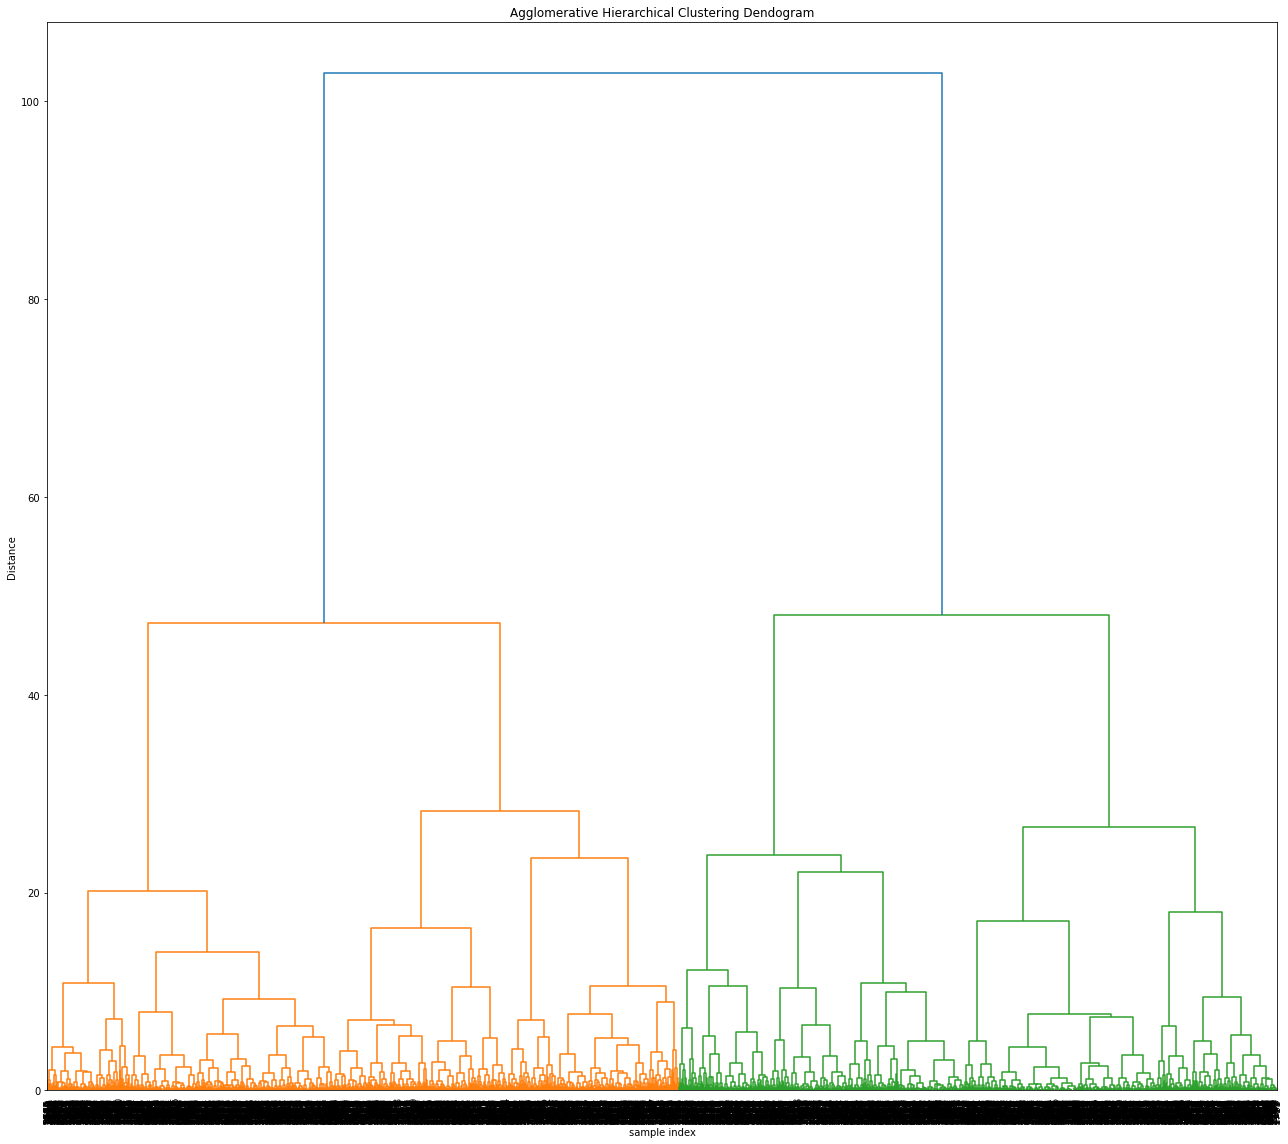

In [187]:
plt.figure(figsize=(18, 16))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')

Z = linkage(rfm_pt_df.iloc[:, :-1], 'ward')
dendrogram(Z,leaf_rotation=90.0,p=25,color_threshold=80,leaf_font_size=10,truncate_mode='level')
plt.tight_layout()

In [190]:
# Hierarchical clustering with n_clusters=2
agc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agc.fit(rfm_pt_df.iloc[:, :-1])

ag_label = agc.labels_
rfm_pt_df['ag_label'] = ag_label
rfm_pt_df.head()

,Recency,Frequency,Monetary,km_label,ag_label
0,1.685545,-1.147956,3.617133,1,1
1,-1.735283,1.489684,1.638269,1,1
2,-2.224939,2.348316,2.472318,1,1
3,-1.591953,0.913713,0.527218,1,1
4,-1.591953,0.680599,0.182384,1,1


# PCA

In [196]:
x = rfm_pt_df.iloc[:, :-2]
x.head(2)

,Recency,Frequency,Monetary
0,1.685545,-1.147956,3.617133
1,-1.735283,1.489684,1.638269


In [197]:
# Find number of components using PCA
from sklearn.decomposition import PCA

cov_matrix = np.cov(x.T)
print('Covariance Matrix \n%s', cov_matrix)

eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

print('Eigen vectors \n%s', eig_vecs)
print()
print('Eigen values \n%s', eig_vals)

tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print('Cumulative variance explained', cum_var_exp)

Covariance Matrix 
%s [[ 1.00025913 -0.56297913 -0.35054778]
 [-0.56297913  1.00025913  0.70412706]
 [-0.35054778  0.70412706  1.00025913]]
Eigen vectors 
%s [[-0.51336742  0.80253953 -0.30394769]
 [ 0.63643117  0.11844742 -0.76218474]
 [ 0.57568156  0.58472259  0.57156822]]

Eigen values 
%s [2.09129324 0.66176287 0.2477213 ]
Cumulative variance explained [ 69.691715    91.74476264 100.        ]


In [212]:
# For 90% explained variance, choose n_components=2
pca = PCA(n_components=2)
pca.fit(x)

# Dataframe with PCA and labels
pca_df = pd.DataFrame(pca.transform(x), columns=['PC1', 'PC2'])
final_df = pd.concat((pca_df, rfm_pt_df.iloc[:, [-2, -1]]), axis=1)
final_df.head()

,PC1,PC2,km_label,ag_label
0,0.486418,3.331763,1,1
1,2.782041,-0.258251,1,1
2,4.060021,-0.061829,1,1
3,1.702282,-0.861102,1,1
4,1.355406,-1.090346,1,1


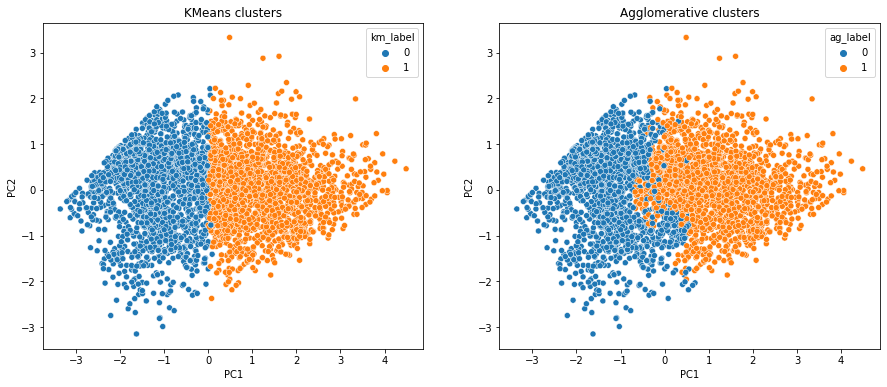

In [219]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(data=final_df, x='PC1', y='PC2', hue='km_label', ax=ax1)
plt.title('KMeans clusters')


ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(data=final_df, x='PC1', y='PC2', hue='ag_label', ax=ax2)
plt.title('Agglomerative clusters')
plt.show()

* Kmeans cluster technique is giving good rpresentation of clusters, hence further modelling is done based on it.

# Model builiding

In [220]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [228]:
# split data into 70:30 ratio
x = final_df.iloc[:, :2]
y = final_df.iloc[:, [2]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [231]:
# Logistics regression algorithm
lor = LogisticRegression()
lor.fit(x_train, y_train)

y_train_pred = lor.predict(x_train)
y_train_prob = lor.predict_proba(x_train)[:, 1]

print('Accuracy score for train is :', accuracy_score(y_train, y_train_pred))
print('ROC score for train is :', roc_auc_score(y_train, y_train_pred))
print('confusion matrix for train is :\n', confusion_matrix(y_train, y_train_pred))

y_test_pred = lor.predict(x_test)
y_test_prob = lor.predict_proba(x_test)[:, 1]

print('Accuracy score for test is :', accuracy_score(y_test, y_test_pred))
print('ROC score for test is :', roc_auc_score(y_test, y_test_pred))
print('confusion matrix for test is :\n', confusion_matrix(y_test, y_test_pred))

Accuracy score for train is : 0.9951887490747594
ROC score for train is : 0.9951956616166271
confusion matrix for train is :
 [[1387    7]
 [   6 1302]]
Accuracy score for test is : 0.9974093264248705
ROC score for test is : 0.9973985059309292
confusion matrix for test is :
 [[585   1]
 [  2 570]]


In [233]:
# Using the Rondom forest algorithm
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

y_train_pred = rfc.predict(x_train)
y_train_prob = rfc.predict_proba(x_train)[:, 1]

print('Accuracy score for train is :', accuracy_score(y_train, y_train_pred))
print('ROC score for train is :', roc_auc_score(y_train, y_train_pred))
print('confusion matrix for train is :\n', confusion_matrix(y_train, y_train_pred))

y_test_pred = rfc.predict(x_test)
y_test_prob = rfc.predict_proba(x_test)[:, 1]

print('Accuracy score for test is :', accuracy_score(y_test, y_test_pred))
print('ROC score for test is :', roc_auc_score(y_test, y_test_pred))
print('confusion matrix for test is :\n', confusion_matrix(y_test, y_test_pred))

Accuracy score for train is : 1.0
ROC score for train is : 1.0
confusion matrix for train is :
 [[1394    0]
 [   0 1308]]
Accuracy score for test is : 0.9965457685664939
ROC score for test is : 0.99654526361011
confusion matrix for test is :
 [[584   2]
 [  2 570]]


* Using both algorithms, prediction rate for test set is more than 99.5%. Hence any of model can be used for prediction purpose.
* Since no class imbalance is seen and hence good prediction rate is achieved.